<a href="https://colab.research.google.com/github/surkovvv/loan_default_prediction/blob/misha/25_11_LoanDefaultPrediction_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузим все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
X = pd.read_csv("applicationdata.csv")
X.sample(5)

,CustomerID,LoanType,Reason,Application.Date,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,PostalCode,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,ArrearsLevel,IsWrittenOff,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,time.since.last.default,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,...,OverdrawnFees_wages_ratio,UncategorisedDebits_wages_ratio,OtherDebits_wages_ratio,AllOtherCredits_wages_ratio,Utilities_wages_ratio,AtmWithdrawals_wages_ratio,Gambling_wages_ratio,Groceries_wages_ratio,Insurance_wages_ratio,SubscriptionTv_wages_ratio,Telecommunications_wages_ratio,Transport_wages_ratio,Wages_repaymentcapacity_ratio,Centrelink_repaymentcapacity_ratio,SaccLoans_repaymentcapacity_ratio,NonSaccLoans_repaymentcapacity_ratio,DebtConsolidation_repaymentcapacity_ratio,DebtCollection_repaymentcapacity_ratio,Rent1_repaymentcapacity_ratio,OverdrawnFees_repaymentcapacity_ratio,UncategorisedDebits_repaymentcapacity_ratio,OtherDebits_repaymentcapacity_ratio,AllOtherCredits_repaymentcapacity_ratio,Utilities_repaymentcapacity_ratio,AtmWithdrawals_repaymentcapacity_ratio,Gambling_repaymentcapacity_ratio,Groceries_repaymentcapacity_ratio,Insurance_repaymentcapacity_ratio,SubscriptionTv_repaymentcapacity_ratio,Telecommunications_repaymentcapacity_ratio,Transport_repaymentcapacity_ratio,Income_MonthlyRepayments_ratio,NonDiscretionarySpending_MonthlyRepayments_ratio,DiscretionarySpending_MonthlyRepayments_ratio,RepaymentCapacity_MonthlyRepayments_ratio,MaxCdia,Isdefault,Isapproved,Inrange,Hasjson
10845,155615.0,Repeat,"Consolidate debt (e.g. store card, loan and cr...",2017-03-10 11:33:04.237,More than 1 year,Retail,10000.0,2200.0,2200.0,12 months,20.0,hotmail.com,Rent,F,Single,0,Blacktown,New South Wales,2148.0,Fortnightly,MACC,A4,Part time,36 months,M3,1.0,30.00,20.00,30.00,1.00,0.0,0.0,0.0,0.0,NaN,1.0,3.0,4.0,4.0,6.0,...,0.0,0.0000,0.0197,1.2232,0.0000,0.1630,0.0004,0.0000,0.0,0.0000,0.0000,0.0000,2.3694,0.0,0.0000,0.0737,0.0000,0.0,0.6546,0.0000,0.000,0.0468,2.8984,0.0000,0.3862,0.0011,0.0000,0.0,0.0000,0.0000,0.0000,10.4114,4.3149,1.7024,4.3940,109.0,1.0,1.0,1.0,1.0
3332,48943.0,New,"Tuition Fees (e.g. university, college or scho...",2017-03-11 13:59:17.747,More than 1 year,"Manufacturing, Trades and Service",4500.0,2500.0,2500.0,12 months,20.0,gmail.com,Own,F,Single,0,Doncaster,Victoria,3108.0,Weekly,MACC,A5,Full time,24 months,M3,0.0,27.00,20.00,33.00,15.00,0.0,0.0,0.0,0.0,NaN,1.0,2.0,3.0,4.0,13.0,...,0.0,0.0000,0.0000,2.3241,0.0000,0.0849,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,1.5820,0.0,0.2245,0.0134,0.0235,0.0,0.0000,0.0001,0.000,0.0000,3.6768,0.0000,0.1344,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,11.7510,3.3247,0.9985,7.4278,103.0,0.0,1.0,1.0,1.0
10278,196782.0,New,Purchase,2017-01-11 14:52:28.073,Less than 3 months,Admin/Office support,3000.0,2100.0,2100.0,9 months,19.0,gmail.com,Rent,F,Single,0,Upwey,Victoria,3158.0,Fortnightly,MACC,A5,Part time,5 months,NaN,0.0,1.00,19.00,1.00,NaN,0.0,0.0,0.0,0.0,NaN,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0000,0.0415,1.7973,0.0000,0.0987,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,1.7735,0.0,0.0000,0.0000,0.0000,0.0,0.3094,0.0000,0.000,0.0736,3.1877,0.0000,0.1751,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,1.5963,0.2785,0.4177,0.9000,0.0,0.0,1.0,1.0,1.0
11826,259247.0,New,"Holiday, Travel & Accommodation",2017-08-09 17:12:00.970,More than 1 year,Customer Service & Call Center,5000.0,5000.0,5000.0,24 months,42.0,iinet.net.au,Rent,M,Married,0,Doubleview,Western Australia,6018.0,Fortnightly,MACC,A3,Full time,24 months,NaN,0.0,273.89,510.92,22.95,71.87,0.0,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,4.0,...,0.0,0.0042,0.0207,2.0468,0.0431,0.0019,0.0000,0.0756,0.0,0.0000,0.0208,0.0000,1.7671,0.0,0.0000,0.1335,0.0000,0.0,0.0000,0.0000,0.007,0.0347,3.4314,0.0723,

# Отступ ⬇

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12982 entries, 0 to 12981
Columns: 216 entries, CustomerID to Hasjson
dtypes: float64(194), object(22)
memory usage: 21.4+ MB


In [4]:
features = X.columns.values
features.shape[0]

216

Видно, что признаков очень много, но возникает ощущение, что далеко не все из них полезны

In [5]:
X = X.drop(index=X[X.isna().sum(axis=1) >= 100].index)

In [6]:
#X = df1.drop("Isdefault", axis=1)
#y = df1["Isdefault"]

In [7]:
#y = y.iloc[:-2].astype(int)
X = X.iloc[:-2, :]

In [8]:
print("Столбец количество пропусков количество уникальных значений")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений
CustomerID 0 12279
LoanType 0 2
Reason 0 894
Application.Date 0 12957
Employment.Length 47 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 555
Residential.Status 7 3
Sex 0 2
Marital.Status 136 3
Dependents 136 4
City 2 4177
State 0 9
PostalCode 0 1569
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 7
Employment.Type 0 5
Requested.Duration 0 39
ArrearsLevel 5889 4
IsWrittenOff 0 2
age.of.file 150 2686
age.of.subject 150 2614
time.at.address 150 1756
time.at.employer 1106 908
defaults 150 3
total.value.of.outstanding.defaults 2971 259
defaults.paid 150 3
defaults.12 150 3
time.since.last.default 12348 128
credit.enquiries.1 150 9
credit.enquiries.3 150 17
credit.enquiries.6 150 21
credit.enquiries.12 150 28
credit.enquiries.60 150 50
time.since.last.enquiry 673 902
telco.and.utility.defaults 150 3
telco.and.utility.defaults.12 150 3
telco.and.utility.enquiries 

#### ***Видно***, что всякие признаки, названия которых оканчиваются на num, CC, PL, Tran и ratio имеют непривлекательно много пропусков, к тому же, для CC, PL, Tran префиксы совпадают для признаков, оканчивающихся на All, так что возможно, что это по сути одно и то же, просто с разных сторон. Для All очень мало пропусков, так что сначала мы и возьмем в нашу модель

In [9]:
bad_features = []
for col_name in X.columns:
    if (col_name.endswith("num") or col_name.endswith("_CC") or col_name.endswith("_PL") or 
        col_name.endswith("_Tran") or col_name.endswith("_ratio")):
        bad_features.append(col_name)
X.drop(columns=bad_features, inplace=True)

## Мое предположение, что от адреса электронной почты, postal code и applycationDate таргет слабо зависит, можно их дропнуть(сделаем из даты 2 новых столбца - год и месяц), а так же удалим признаки, способствующих переобучению (по заявлению автора статьи) IsWrittenOff, MaxCdia, а так же последние три признака - у них всего 1 уникальное значение, это ни о чем не скажет нашей модели

## Второе замечание - уникальных ID всего 12300, надо с ними разобраться..

In [10]:
X['Year'] = X['Application.Date'].apply(lambda x : int(x[:4]))
X['Month'] = X['Application.Date'].apply(lambda x : int(x[5:7]))
X.drop("Application.Date", axis=1, inplace=True)

In [11]:
X.drop(columns=["PostalCode", "contributing.factors", "TDatePart","time.since.last.default", 
                "IsWrittenOff", "MaxCdia", "Isapproved", "Inrange", "Hasjson"], inplace=True)

Теперь нам предстоит работа с пропусками - попробуем по максимуму разобраться и адекватно заполнить пропуски - потому что тут есть столбцы с вполне понятными заменами для NaN 

In [12]:
# этот код показывает, сколько будет пропусков в каждом столбце (числовом), если в нем убрать строки с NaN'овыми age.of.file
# аналогично можно поступить с окончанием ratio и All 
# в итоге, мы потеряем около 1100 строк (для ratio можно просто удалить все эти столбцы..)

# это основано на том, что эти столбцы идут пачками, если в строке NaN в age.of.file, то в этой же строке NaN и в age.of.subject, и в других соседних
bad_cols = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X.loc[X[X["age.of.file"].notna()].index][col].isna().sum()
    if number_of_nans > 0:
        bad_cols.append((col, number_of_nans))
 

In [13]:
# Посмотрим, что за столбцы, и сколько в них пропусков:
bad_cols

[('time.at.employer', 956),
 ('total.value.of.outstanding.defaults', 2821),
 ('time.since.last.enquiry', 523),
 ('Subscription_TV', 9735),
 ('currentBalance_All', 1),
 ('availableBalance_All', 1),
 ('openingBalance_All', 1),
 ('totalCredits_All', 1),
 ('totalDebits_All', 1),
 ('closingBalance_All', 1),
 ('daysInNegative_All', 1),
 ('totalTX_All', 5),
 ('totalCR_All', 5),
 ('totalDR_All', 5),
 ('totalCRvalue_All', 5),
 ('totalDRvalue_All', 5),
 ('maxCRvalue_All', 5),
 ('minCRvalue_All', 5),
 ('maxDRvalue_All', 5),
 ('minDRvalue_All', 5),
 ('minBalance_All', 5),
 ('maxBalance_All', 5)]

In [14]:
# удалим каскадно те самые 5 строчек, где проблема у стоблцов, оканчивающихся на _All, 
# все остальные заполним нулями
X.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
#y.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
X.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)
#y.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)

Прогоним еще раз, чтобы получить столбцы, которые мы заполним нулями:

In [15]:
bad_cols_2 = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X[col].isna().sum()
    if number_of_nans > 0:
        bad_cols_2.append(col)
for col_name in bad_cols_2:
    X[col_name].fillna(0, inplace=True)

Готово, теперь разберемся с категориальными данными:

In [16]:
import re

def func(List, data):
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    for reason in List:
      if item == reason:
        return item
  return "other"     

Set = set()
Dict = dict()
for data in X["Reason"]:
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    if item in Set:
      Dict[item] += 1
    else:
      Set.add(item)
      Dict[item] = 1
sorted_dict = {}
sorted_keys = sorted(Dict, key=Dict.get)  
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["Reason"] = X["Reason"].apply(lambda x: func(List, x))

In [17]:
def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["City"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["City"] = X["City"].apply(lambda x: func(List, x))


In [18]:

def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["EmailDomain"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["EmailDomain"] = X["EmailDomain"].apply(lambda x: func(List, x))


In [19]:
def func(data):
  if len(data)>2 and data[2] == '+':
    return int(data[1:2])
  else:
    return int(data[1:])
X["Risk.Rating"] = X["Risk.Rating"].apply(lambda x: func(x))

In [20]:
X["Duration"] = X["Duration"].apply(lambda x: int(x.split()[0]))
X["Requested.Duration"] = X["Requested.Duration"].apply(lambda x: int(x.split()[0]))


In [21]:
#print("Столбец количество пропусков количество уникальных значений после обработки")
#for col in X:
#    print(col, X[col].isna().sum(), X[col].nunique())
# Последний штрих:
to_fill = ["Employment.Length", "Employment.Sector", "Residential.Status"]
to_delete_indexes = ["Marital.Status", "Dependents"]
to_delete_col = "ArrearsLevel"

In [22]:
X[to_fill[0]].fillna("3 months to 1 year", inplace=True)
X[to_fill[0]].fillna("Construction, Building & Architecture", inplace=True)
X[to_fill[0]].fillna("Rent", inplace=True)

In [23]:
X.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)
#y.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)

In [24]:
X.drop(columns=[to_delete_col,"CustomerID"], inplace=True)

In [25]:
print("Столбец количество пропусков количество уникальных значений после обработки")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений после обработки
LoanType 0 2
Reason 0 20
Employment.Length 0 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 21
Residential.Status 7 3
Sex 0 2
Marital.Status 0 3
Dependents 0 4
City 0 21
State 0 8
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 6
Employment.Type 0 5
Requested.Duration 0 35
age.of.file 0 2673
age.of.subject 0 2598
time.at.address 0 1748
time.at.employer 0 902
defaults 0 3
total.value.of.outstanding.defaults 0 257
defaults.paid 0 3
defaults.12 0 3
credit.enquiries.1 0 9
credit.enquiries.3 0 17
credit.enquiries.6 0 21
credit.enquiries.12 0 28
credit.enquiries.60 0 50
time.since.last.enquiry 0 894
telco.and.utility.defaults 0 3
telco.and.utility.defaults.12 0 3
telco.and.utility.enquiries 0 12
telco.and.utility.enquiries.6 0 5
telco.and.utility.enquiries.12 0 6
directorships.current 0 7
directorships.previous 0 8
adverse.on.file 0 4
applicant.odd

## Итоги: 

### Мы максимально почистили датасет, при чем нам пришлось срезать как немного признаков, так и немного объектов, но мы надеемся, что это не сильно скажется на обучении наших моделей.

In [26]:
y = X["Isdefault"]
X = X.drop("Isdefault", axis=1)

In [27]:
X.head()

,LoanType,Reason,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,time.since.last.enquiry,telco.and.utility.defaults,telco.and.utility.defaults.12,telco.and.utility.enquiries,telco.and.utility.enquiries.6,telco.and.utility.enquiries.12,...,maxDRvalue_All,minDRvalue_All,minBalance_All,maxBalance_All,EntropyText,EntropyDate,Salary,Rent,LoanCommitments,LivingExpenses,Wages,Centrelink,SaccLoans,NonSaccLoans,DebtConsolidation,DebtCollection,Rent1,OverdrawnFees,UncategorisedDebits,OtherDebits,AllOtherCredits,Utilities,AtmWithdrawals,Gambling,Groceries,Insurance,SubscriptionTv,Telecommunications,Transport,OnGoingSaccCount,DishounorIn90Days,Income,NonDiscretionarySpending,DiscretionarySpending,RepaymentCapacity,RepaymentFromRequested,ExcessCapacity,RepaymentsRatio,Year,Month
0,New,other,More than 1 year,Customer Service & Call Center,2500.0,2500.0,2500.0,12,21.0,live.com.au,Rent,F,Married,0,other,New South Wales,Fortnightly,MACC,5,Full time,24,46.0,21.0,8.0,0.0,1.0,698.0,0.0,1.0,2.0,4.0,5.0,7.0,19.0,0.0,1.0,1.0,2.0,0.0,0.0,...,-725.2,-1.00,1.00,1697.19,6.193471,2.405919,16801.0,700.0,836.0,500.0,-0.005,0.00,0.0000,30.2037,0.0,0.0,700.0,0.0,0.0000,312.2203,15.5462,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,-0.005,1536.0000,500.0000,-2036.0050,161.71,-2197.715,0.0000,2016,11
1,Repeat,other,More than 1 year,Government & Defence,5500.0,3000.0,3000.0,24,26.0,hotmail.com,Rent,M,Married,2,other,Victoria,Fortnightly,MACC,3,Full time,24,82.0,25.0,20.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,...,-2340.5,-1.00,-916.77,6078.60,7.458622,2.252031,2200.0,1000.0,40.0,1000.0,3145.460,2170.89,790.1979,200.2498,0.0,0.0,1000.0,0.0,407.6374,527.9387,3994.2321,209.199,155.4629,0.0,573.8661,120.3012,188.1473,297.3398,6.3165,2.0,0.0,5316.350,1990.4477,1550.6332,1775.2690,303.80,1471.469,17.1128,2016,11
2,New,other,More than 1 year,"Logistics, Transport & Supply",6300.0,6300.0,6300.0,30,37.0,gmail.com,Rent,M,Married,0,other,New South Wales,Fortnightly,PL,4,Full time,36,243.0,37.0,29.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,19.0,2.0,0.0,0.0,2.0,0.0,0.0,...,-500.0,-0.01,-36.20,2458.65,6.653219,2.646279,2526.0,340.0,325.0,370.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11
4,Repeat,other,3 months to 1 year,Other,4500.0,2500.0,2500.0,13,30.0,outlook.com,Living with friends,F,Married,1,other,Northern Territory,Fortnightly,MACC,5,Part time,13,17.0,30.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-200.0,-0.01,-3.70,334.43,5.667073,1.543058,819.0,0.0,0.0,300.0,-0.005,238.14,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,437.6654,0.000,209.5370,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,238.135,0.0000,209.5370,28.5979,440.92,-412.322,0.0000,2016,11
5,New,other,More than 1 year,NaN,3500.0,3500.0,3500.0,18,49.0,hotmail.com,Own,F,Married,0,other,Queensland,Fortnightly,MACC,4,Part time,18,229.0,49.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,5.0,21.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1000.0,-13.31,200.50,1430.42,4.713893,1.826245,1120.0,200.0,0.0,500.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11


In [28]:
pip install lightgbm

In [29]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [30]:
pip install xgboost

In [31]:
#pip install -U KTBoost

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_roc_curve, classification_report, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import xgboost as xgb
#import KTBoost.KTBoost as KTBoost

In [33]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=66)
numeric_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

#scaler = StandardScaler()
#encoder = LabelEncoder()

ohe_cat_df = pd.get_dummies(X[categorical_features])
X.drop(columns=categorical_features, inplace=True)

#X[numeric_features] = scaler.fit_transform(X[numeric_features])
#X = X.join(ohe_cat_df)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=66)

Feature selection by WOE and IV
написать функцию которая строить графики распределения значений всех столбцов: по 5 столбцов 

IndexError: ignored

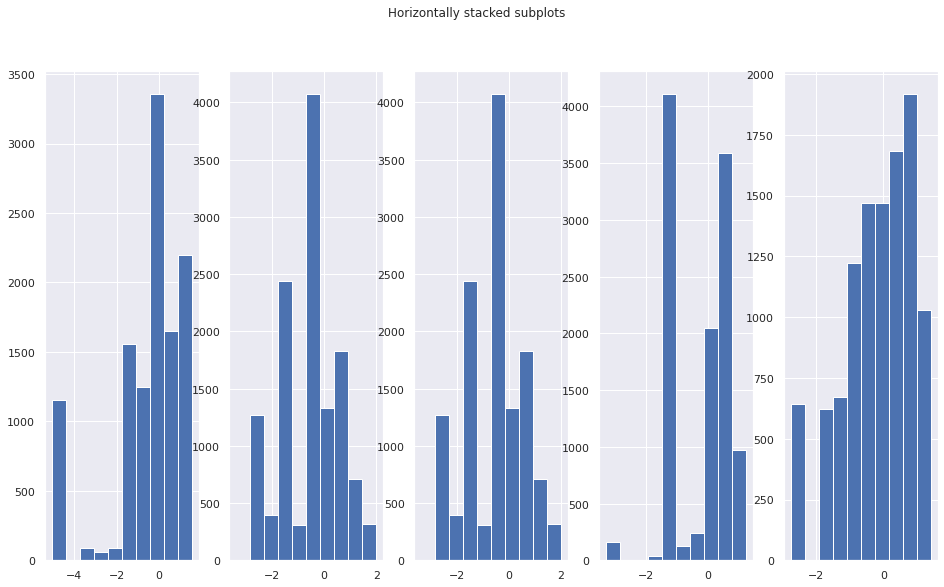

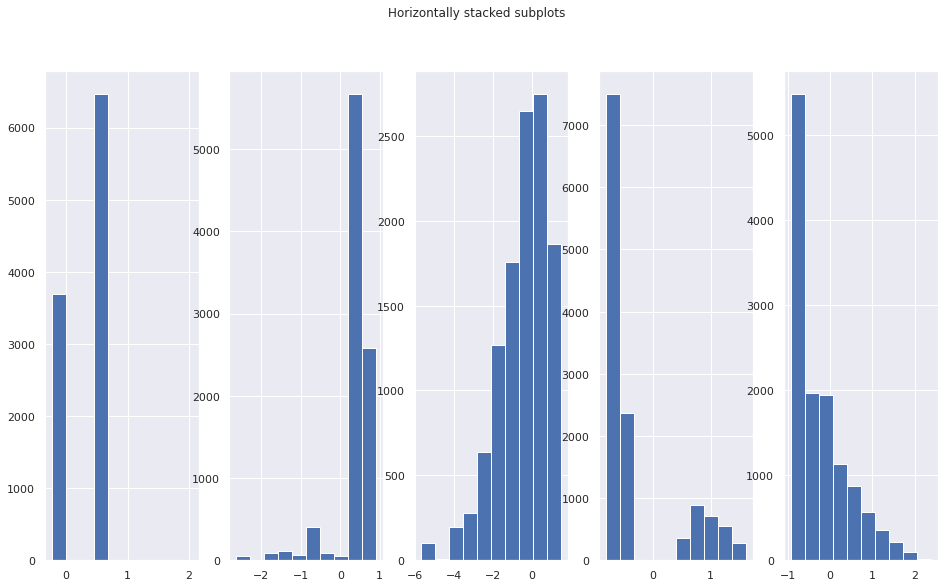

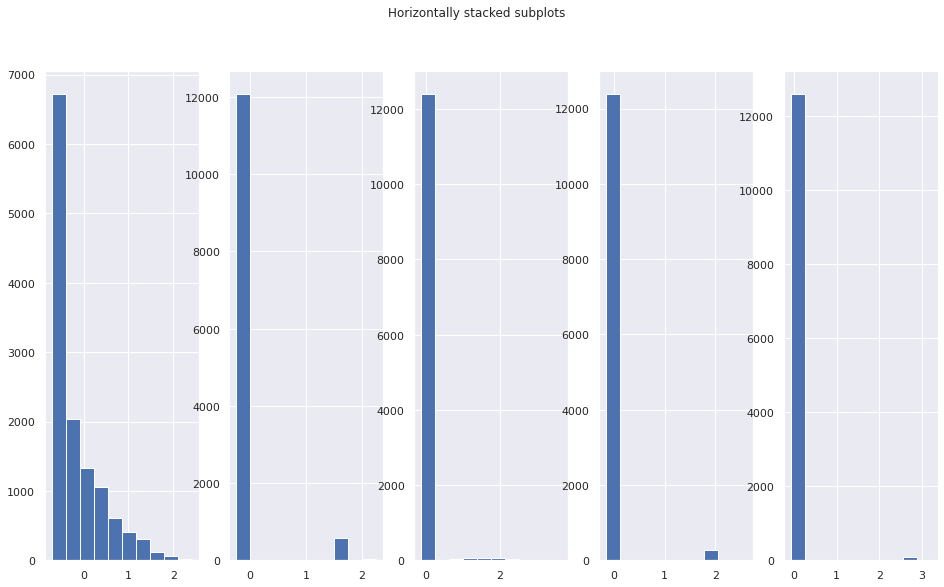

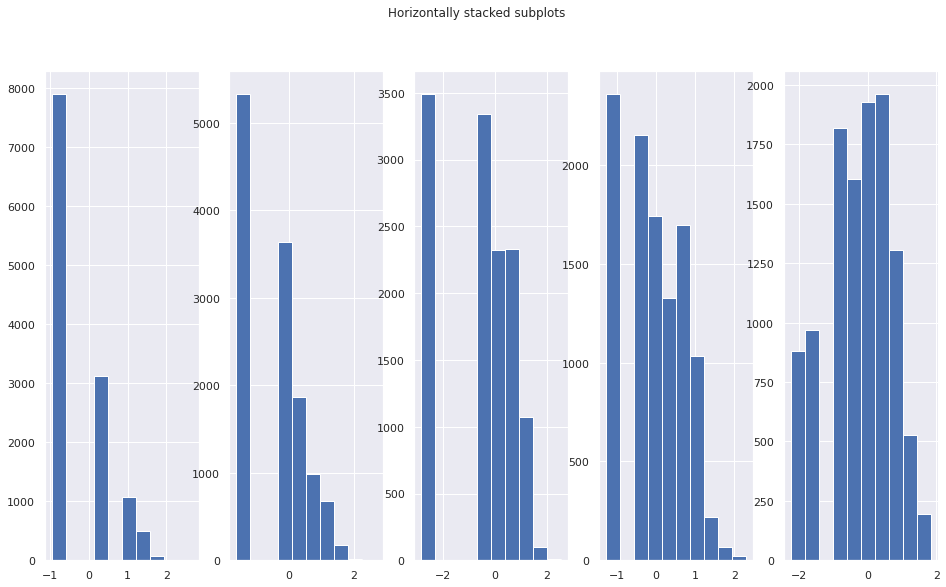

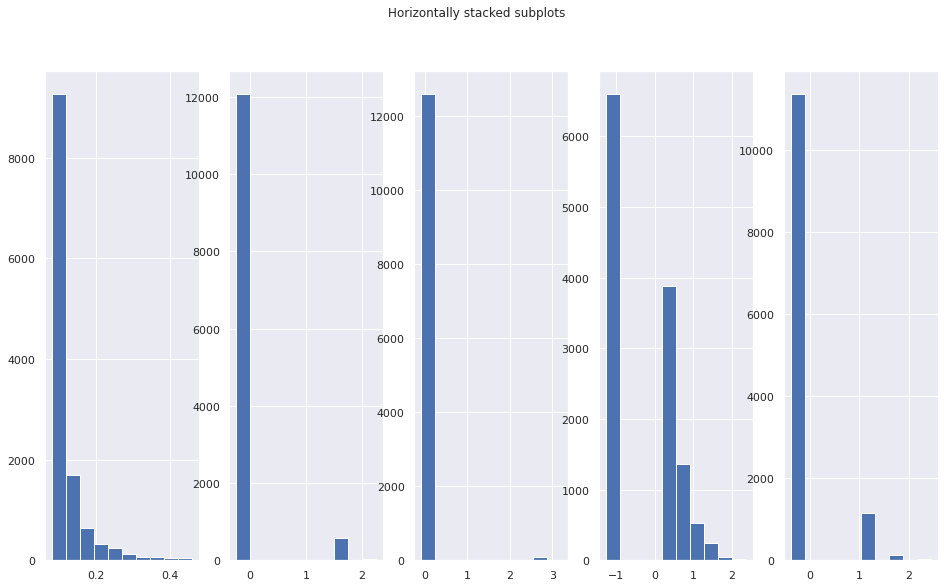

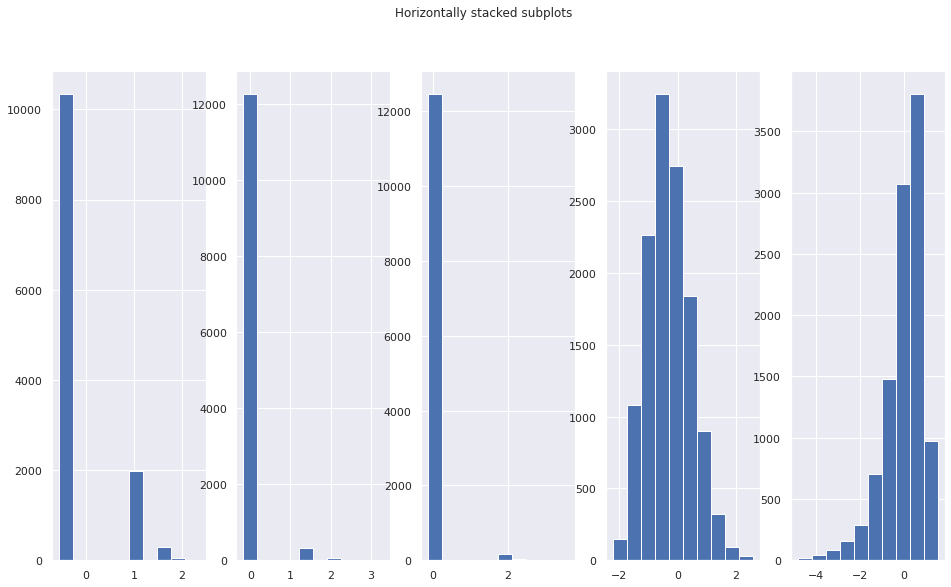

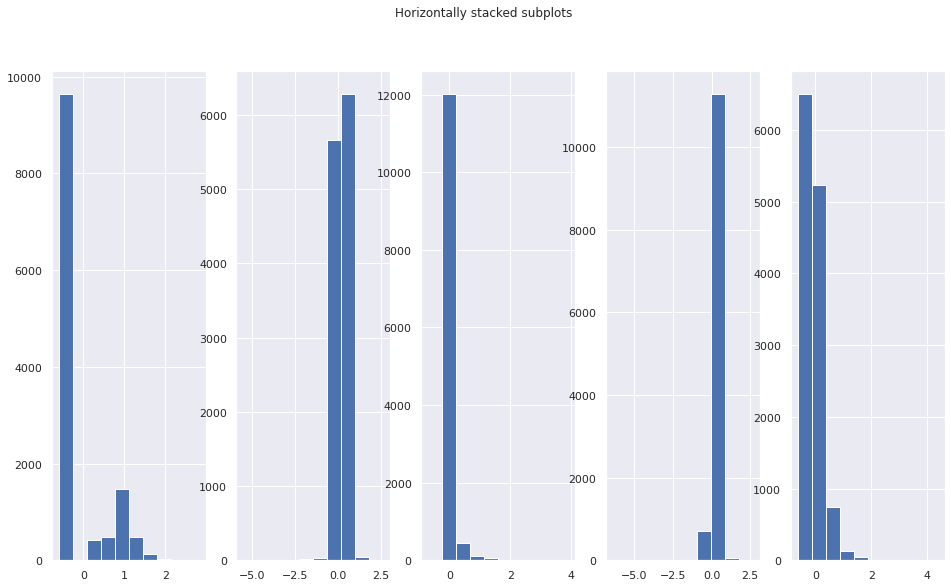

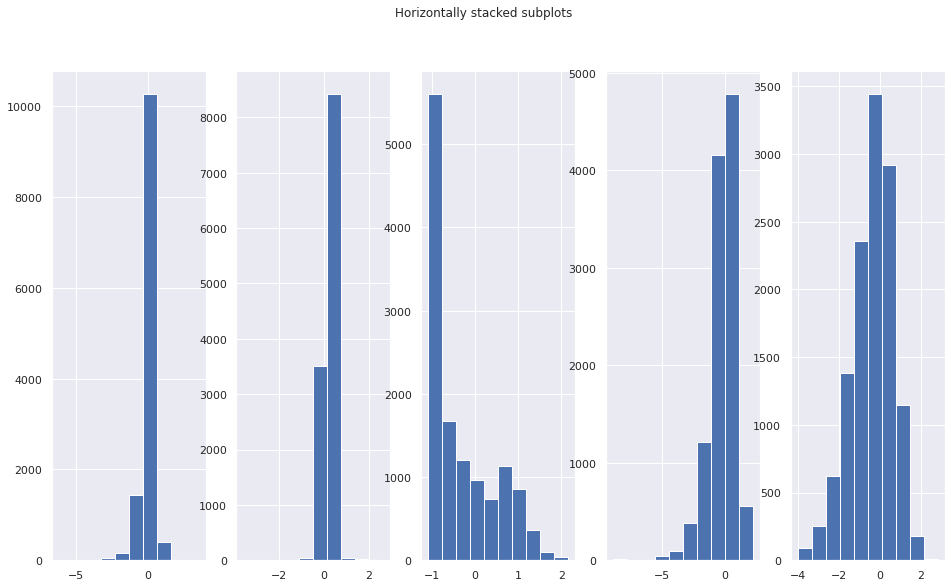

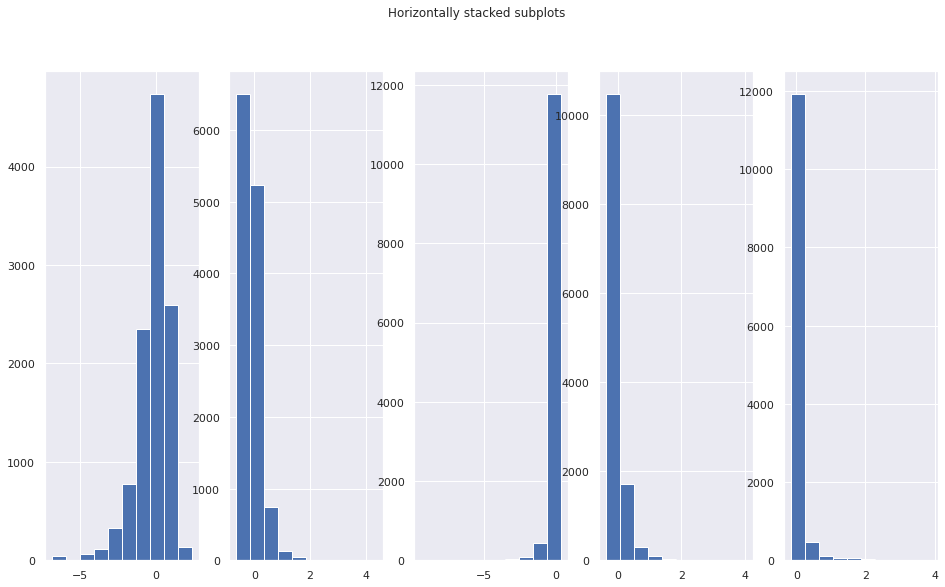

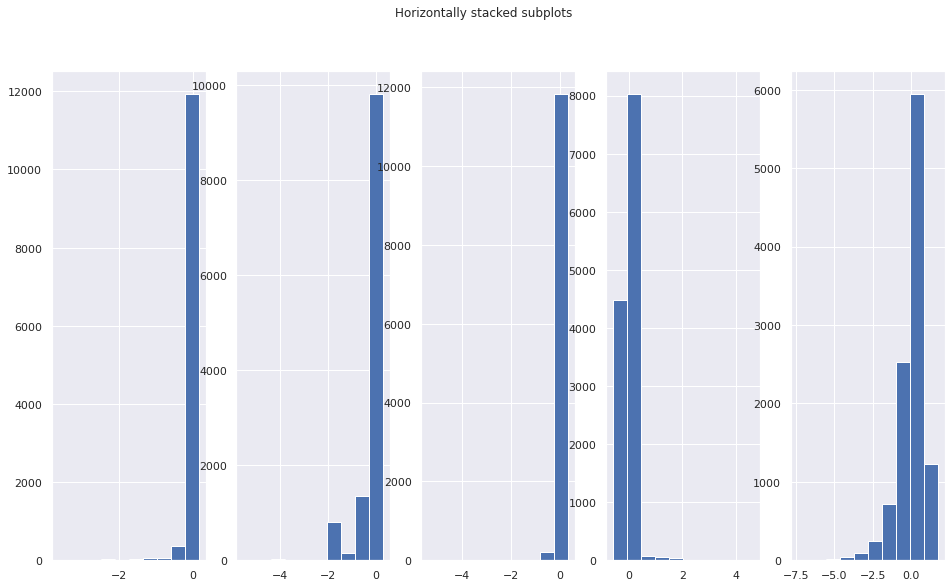

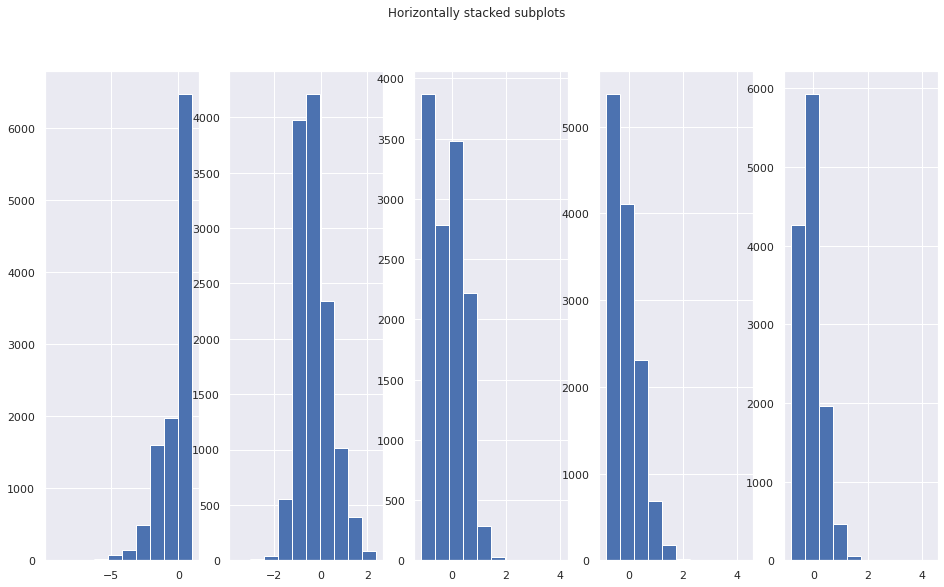

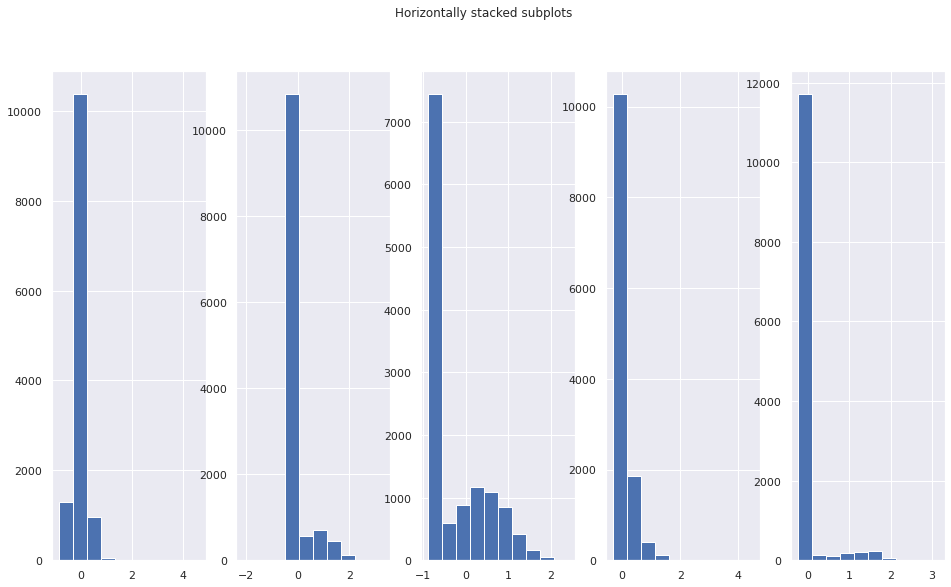

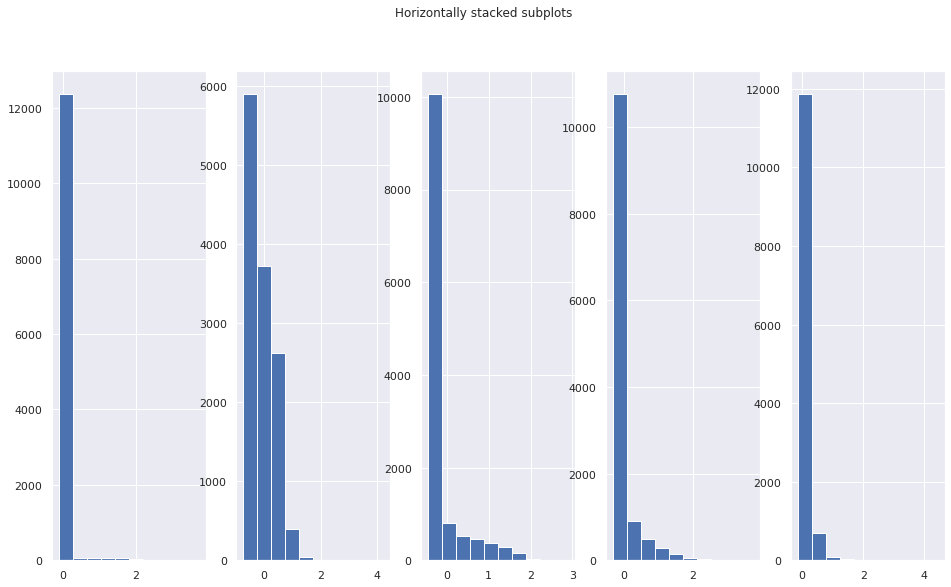

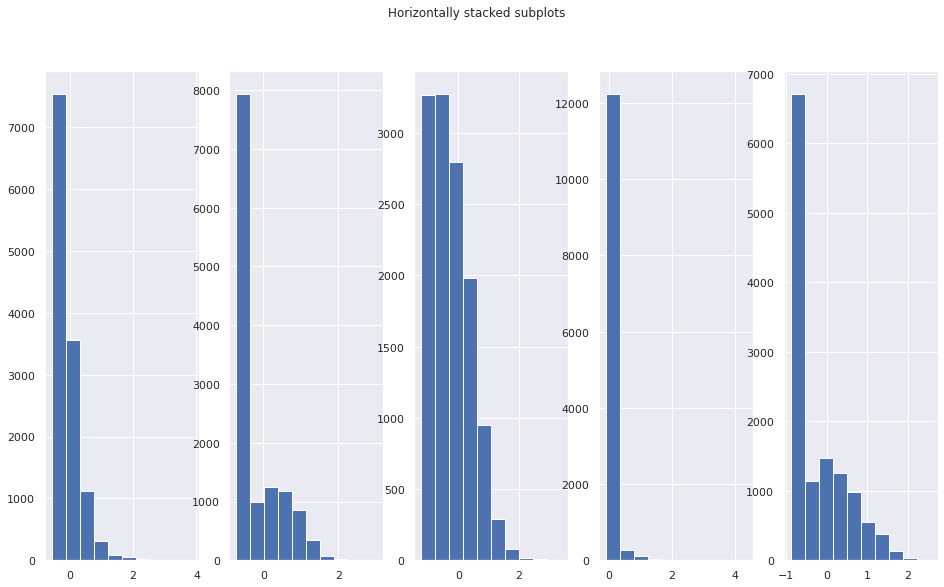

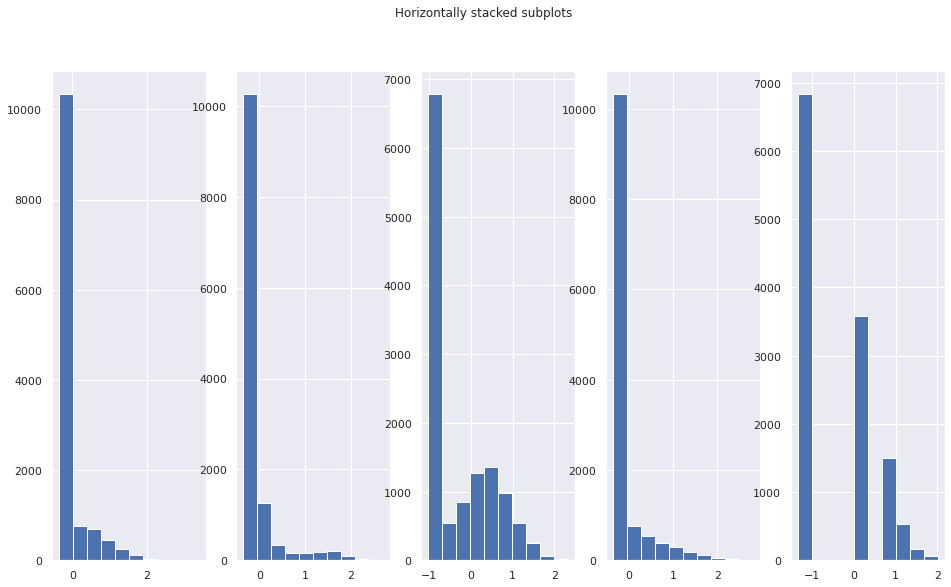

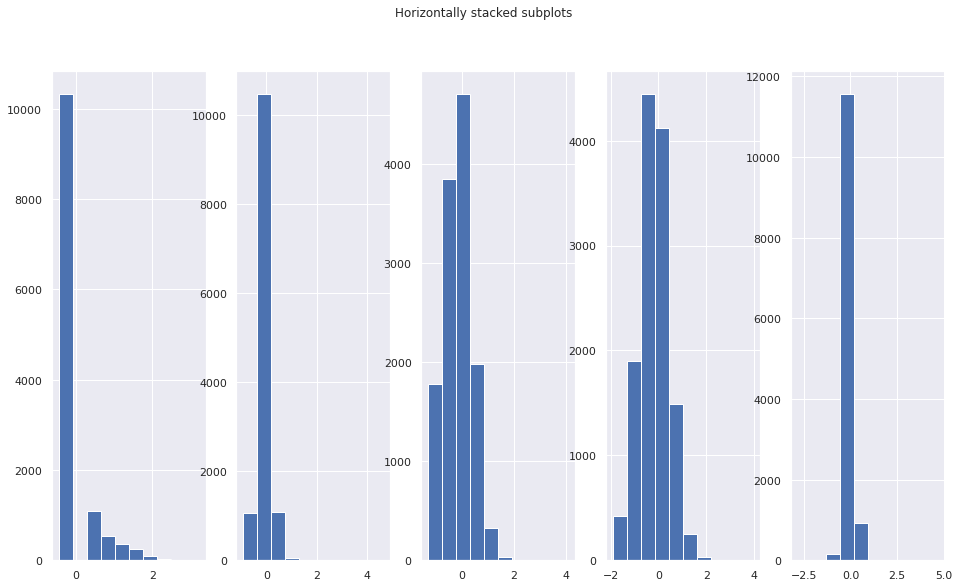

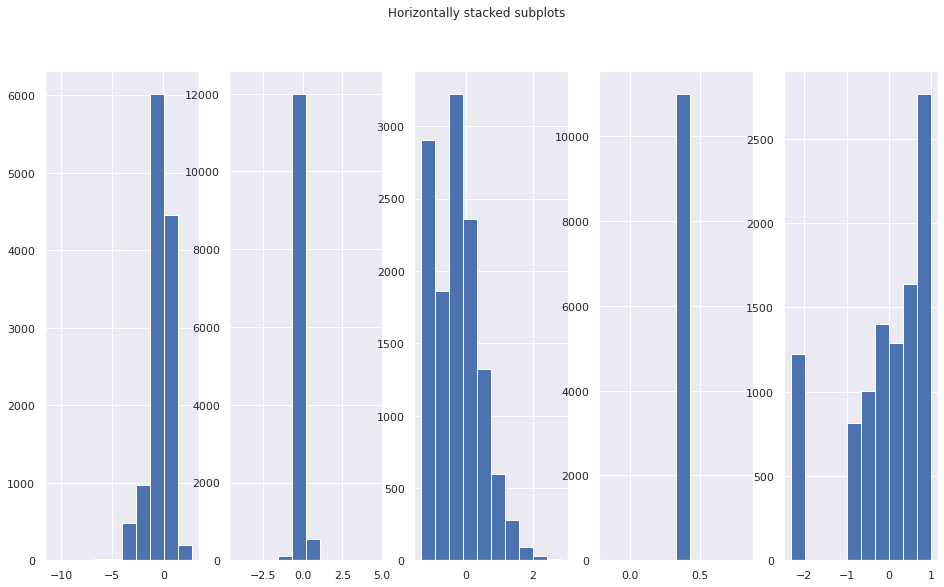

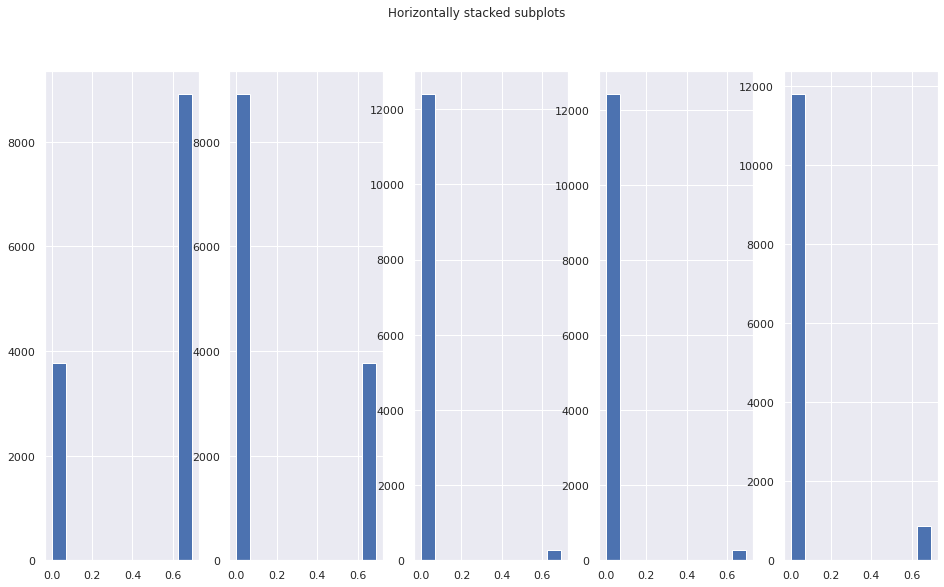

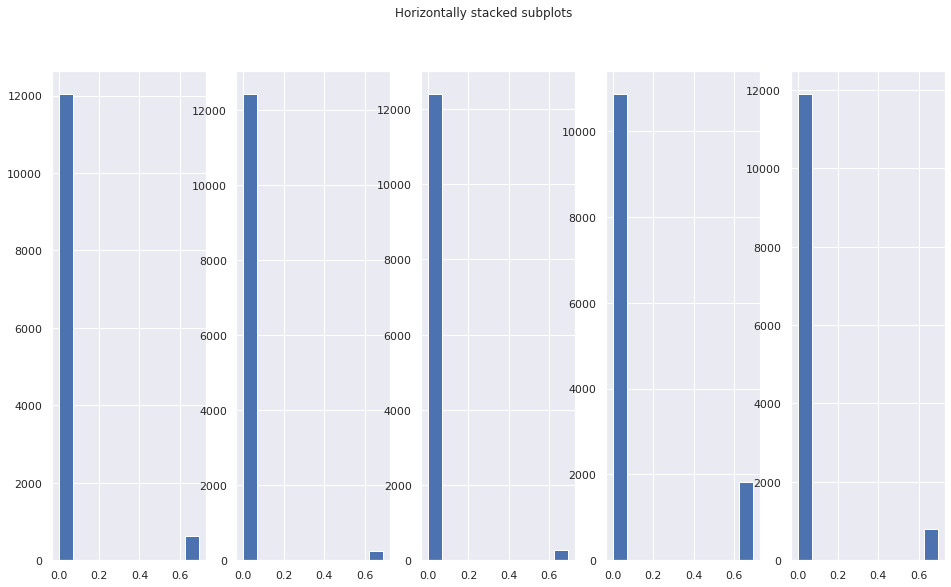

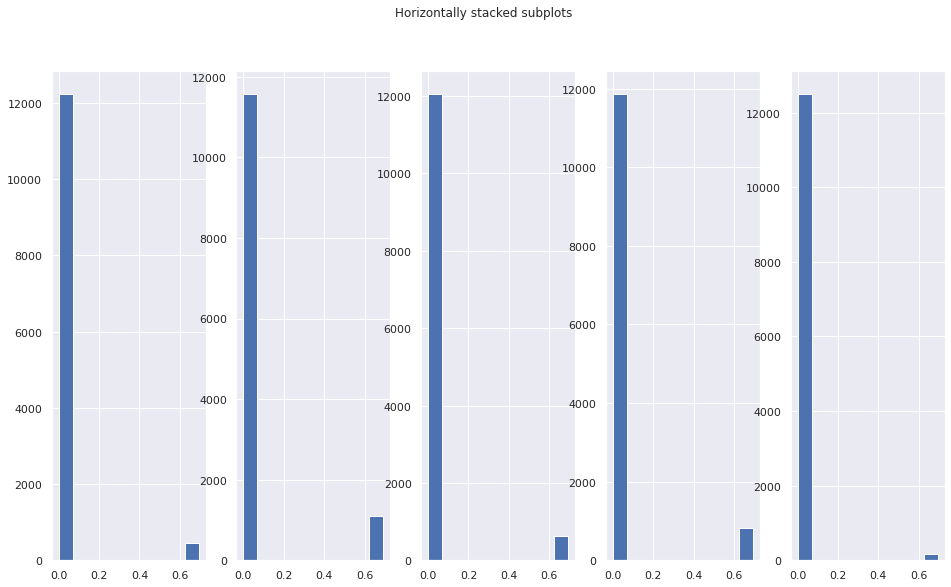

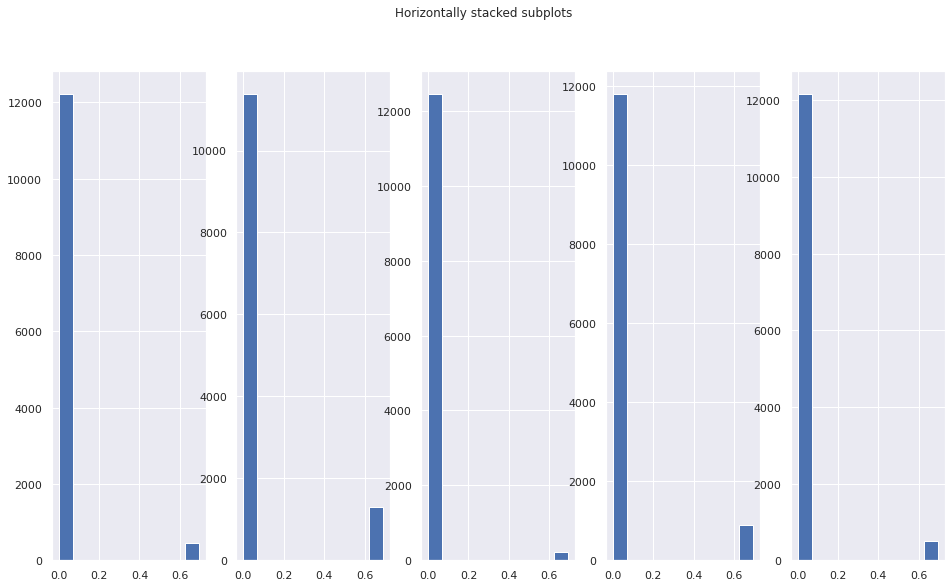

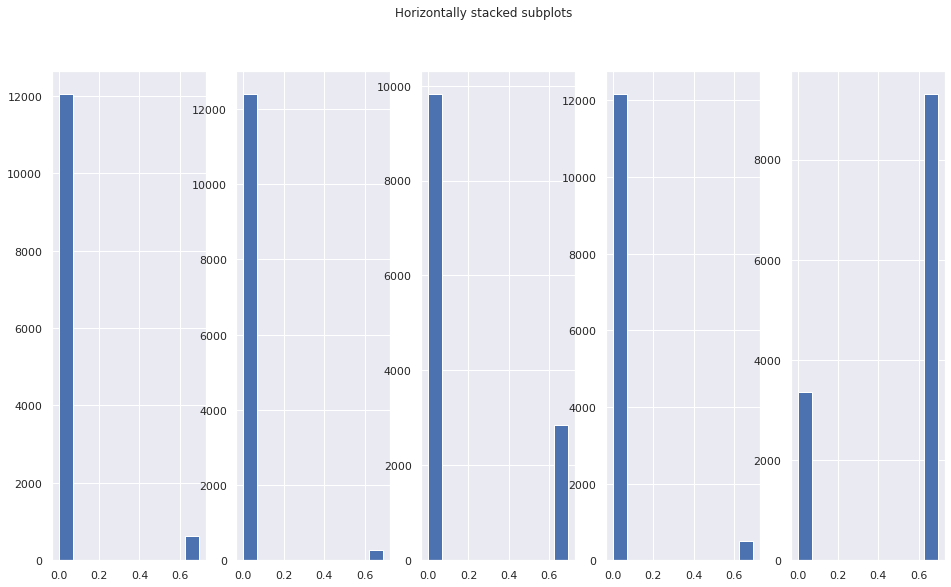

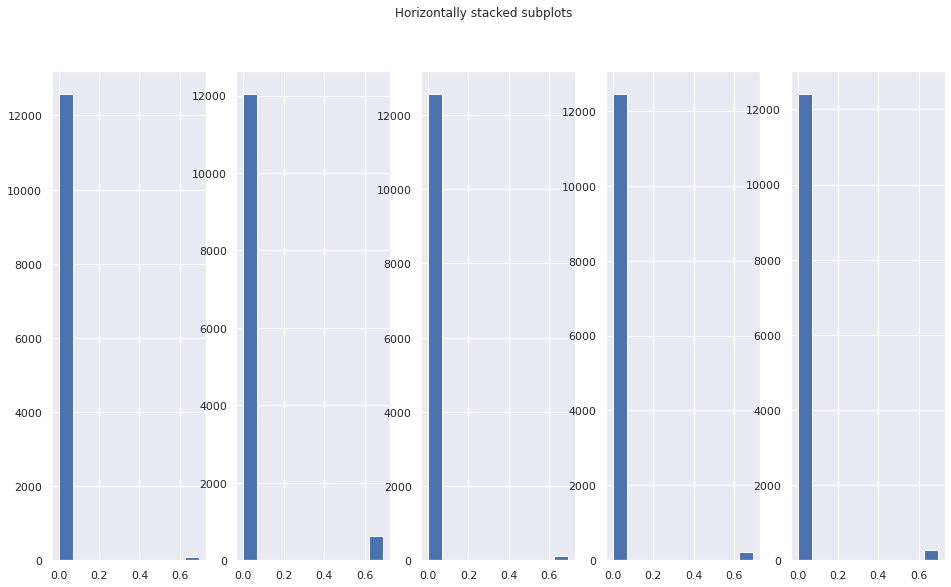

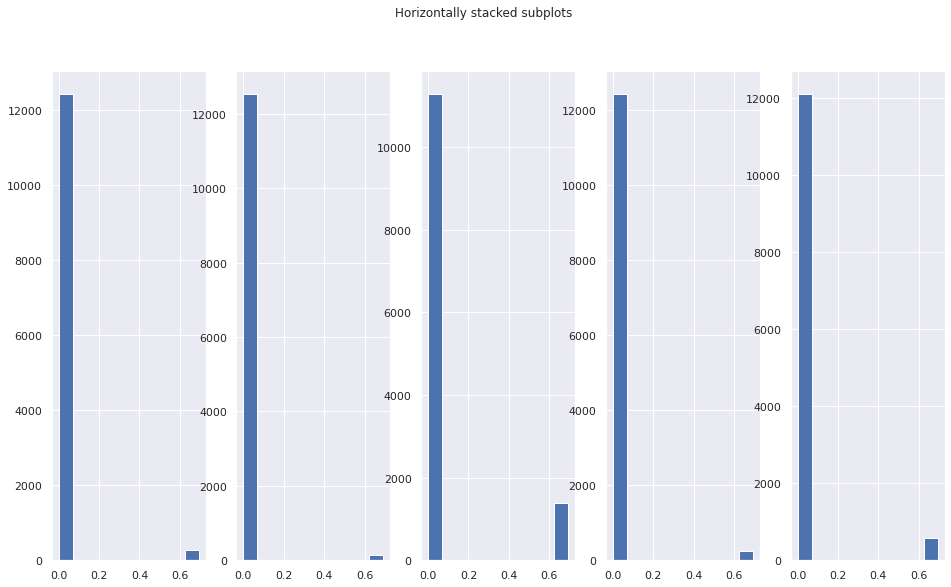

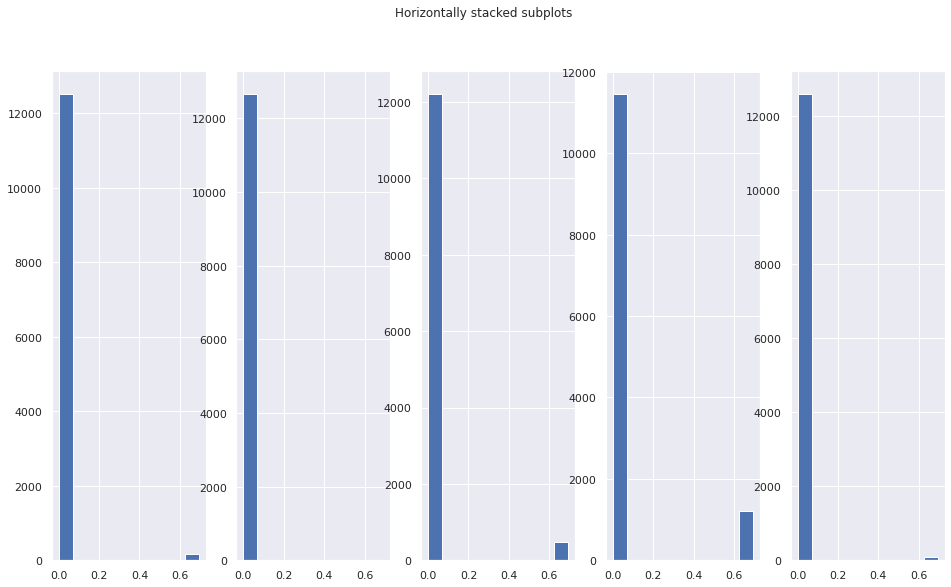

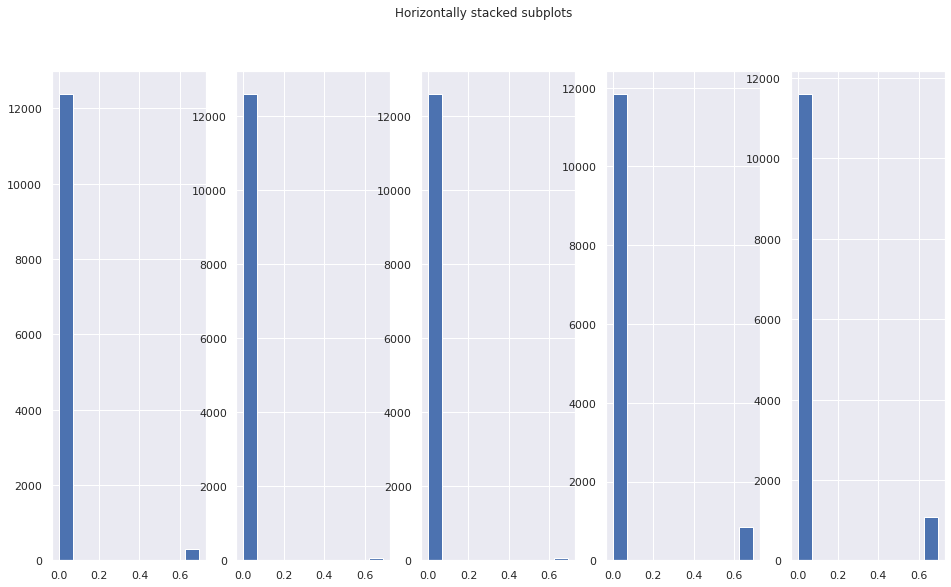

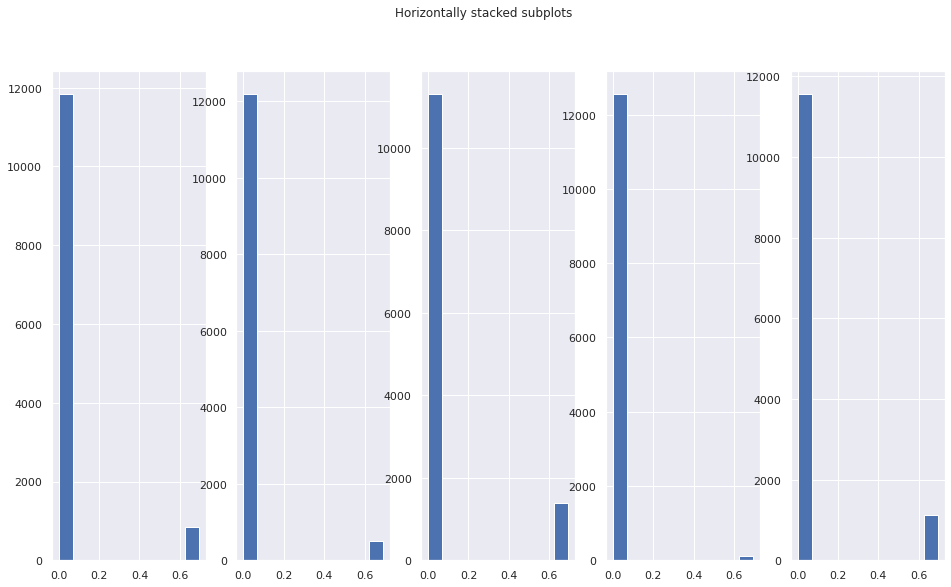

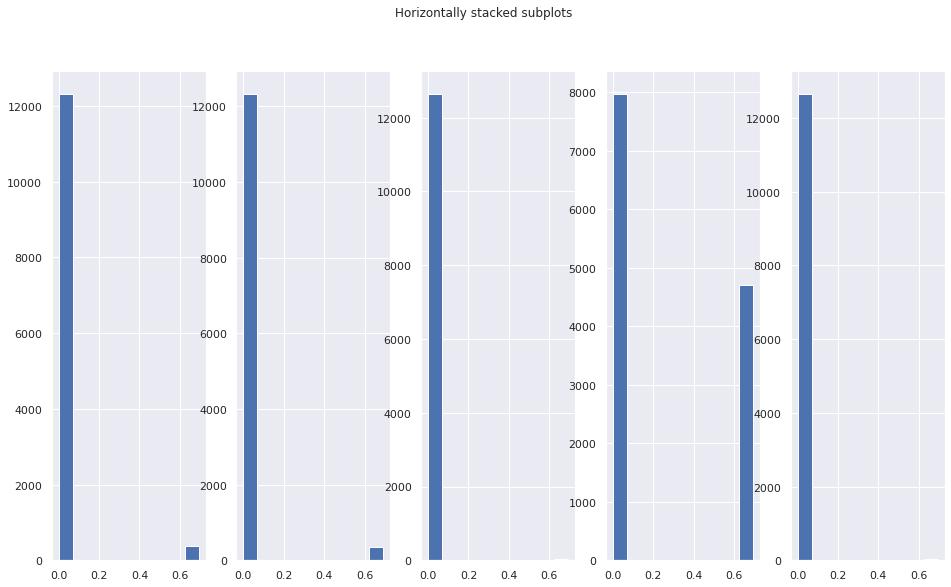

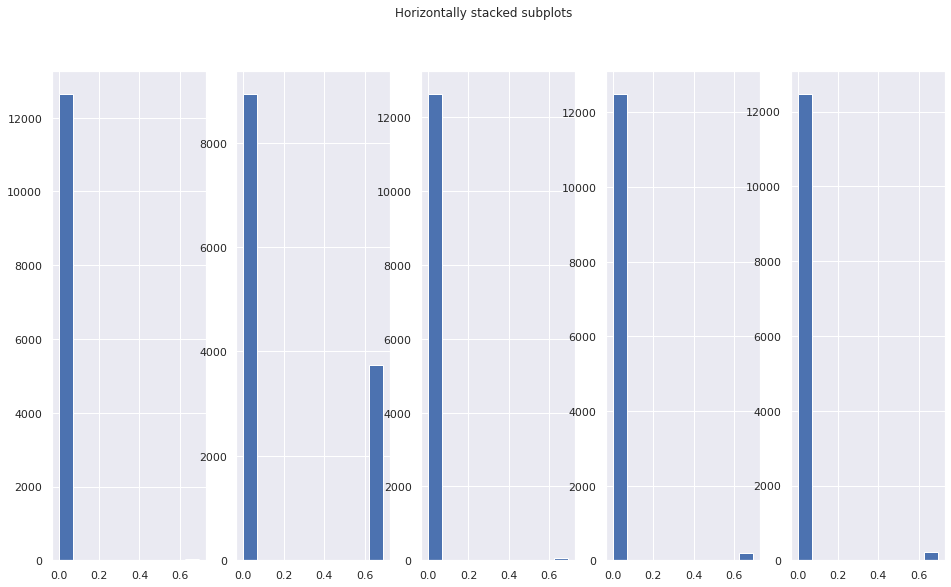

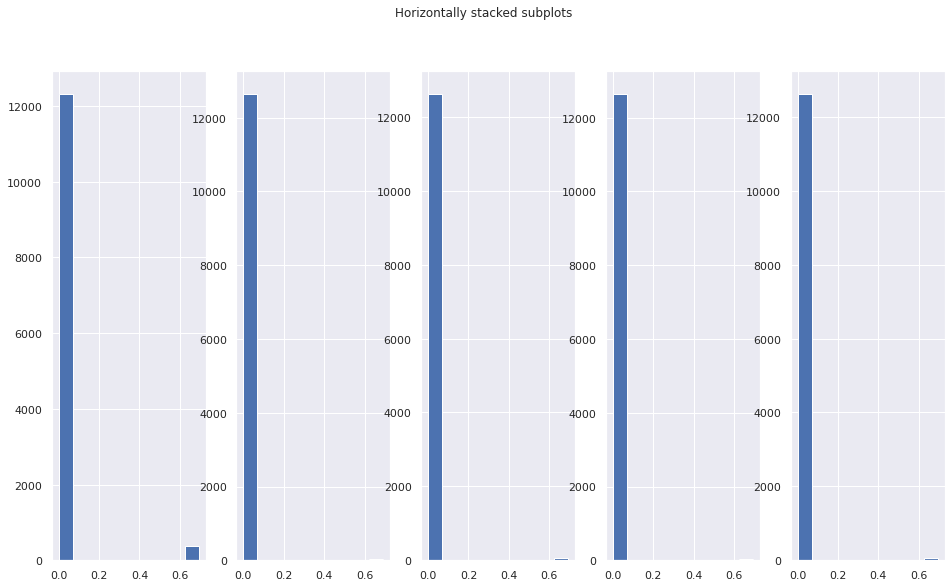

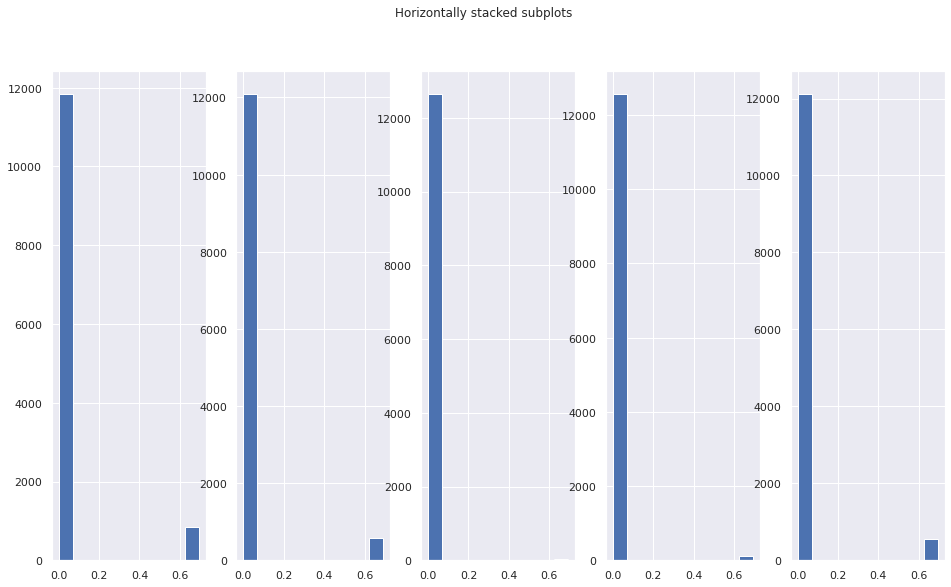

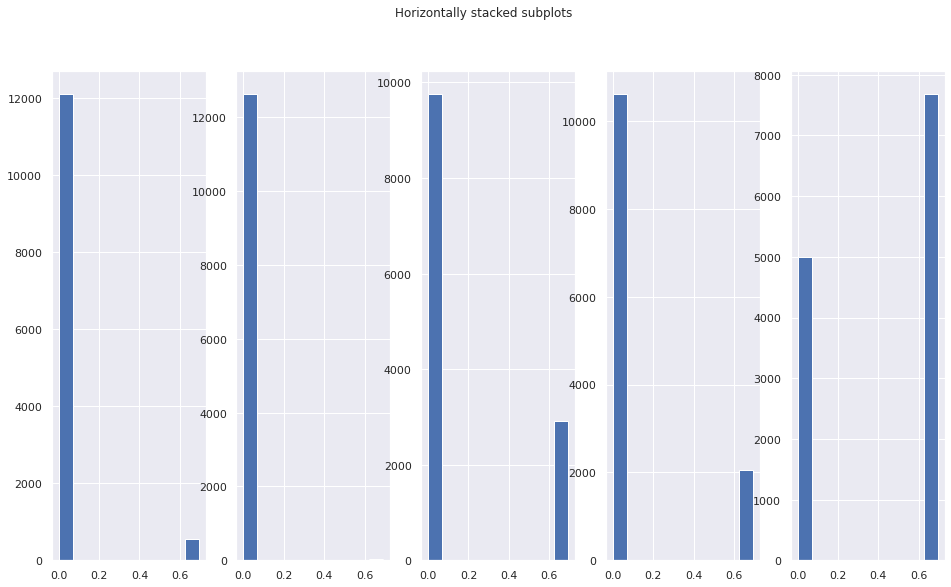

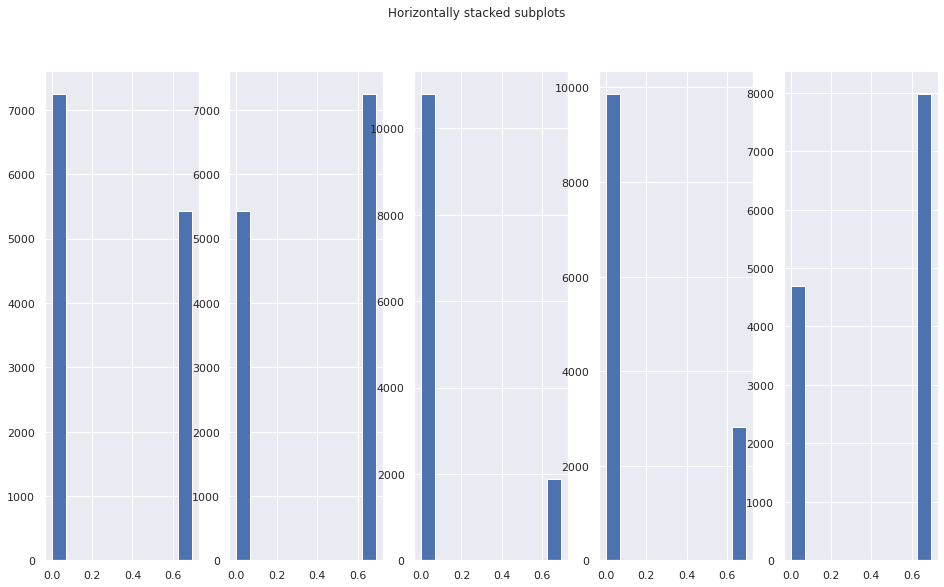

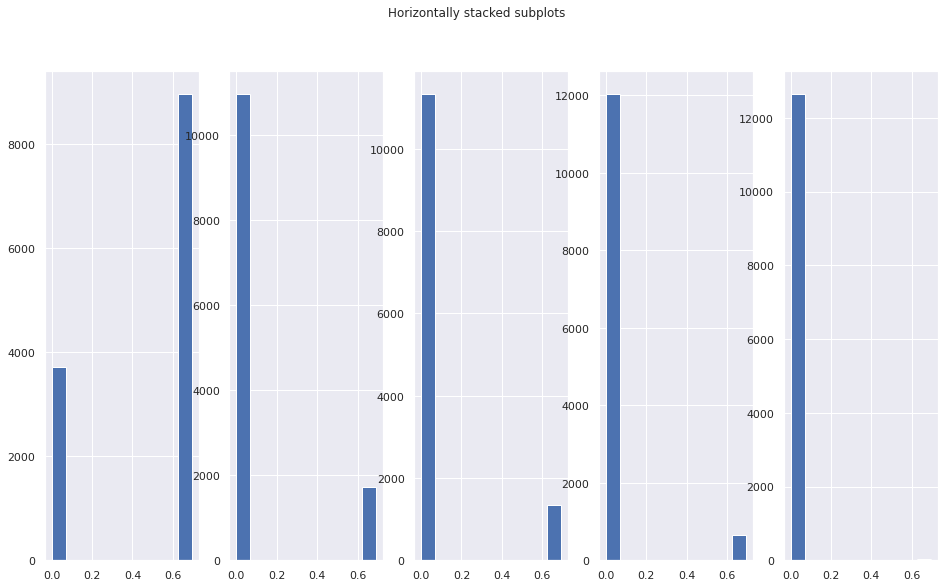

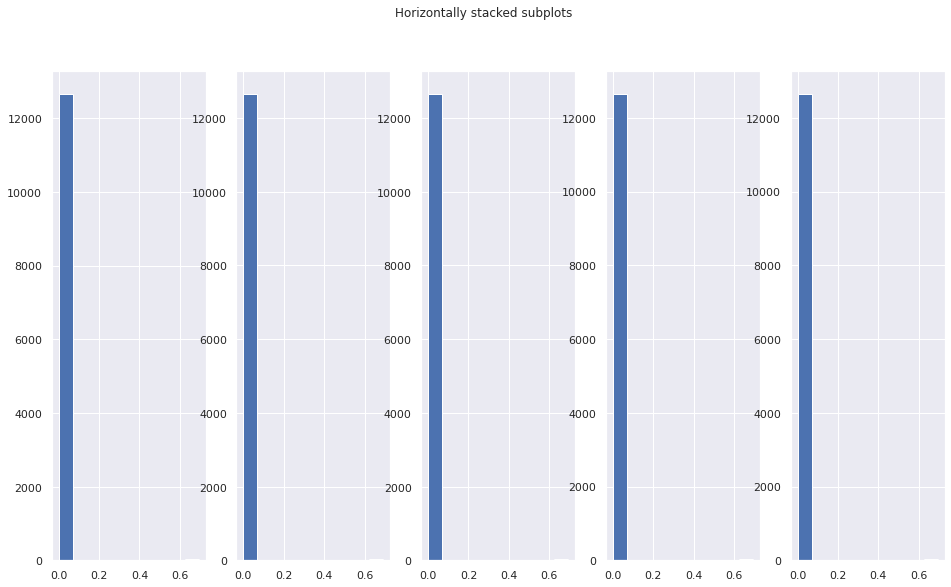

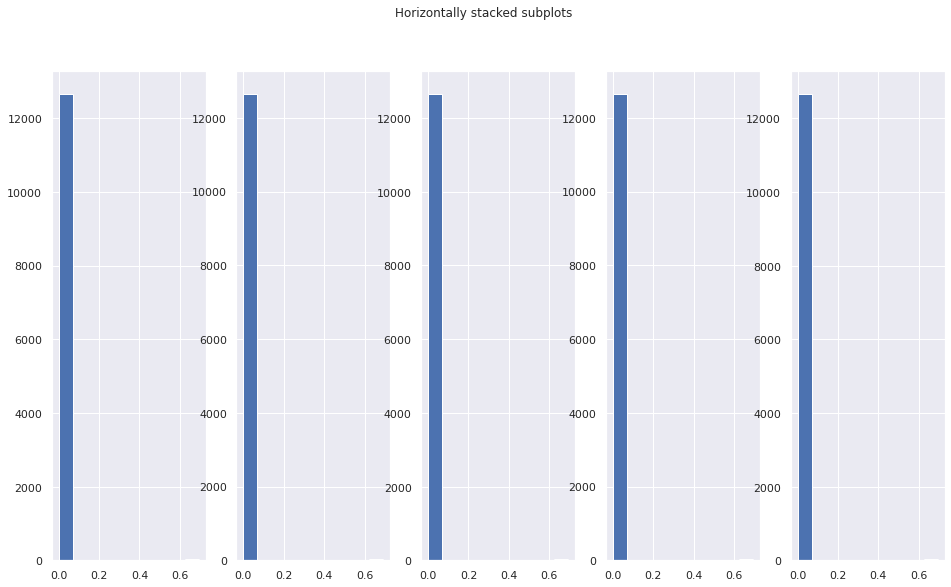

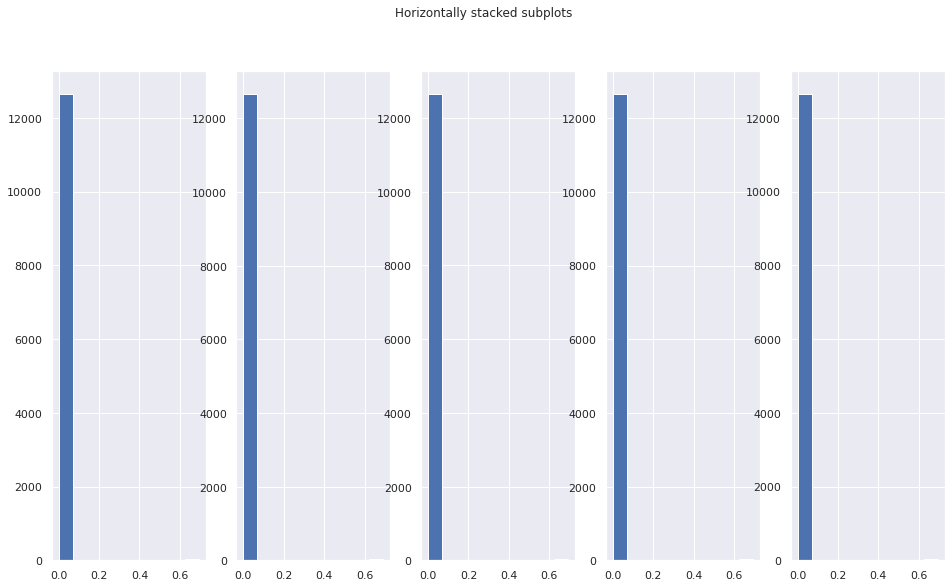

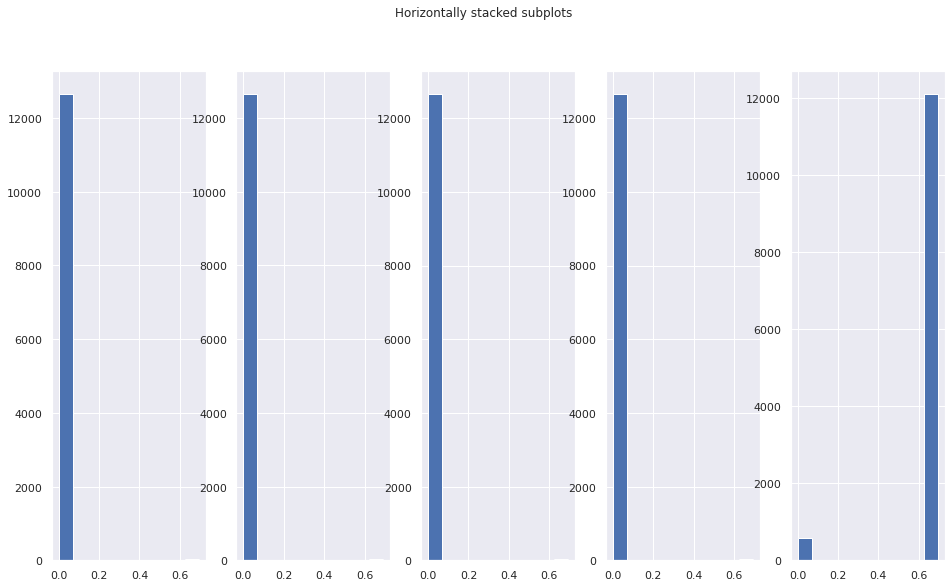

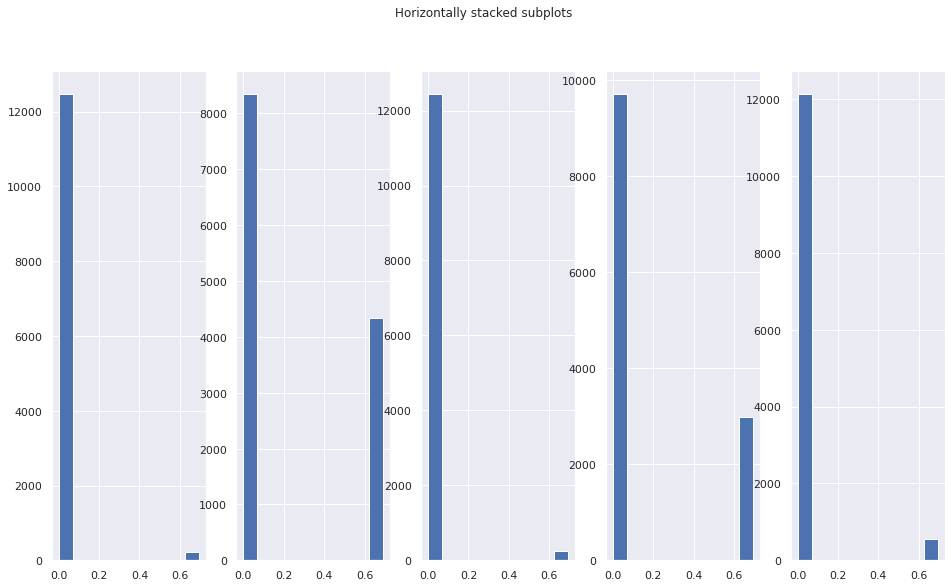

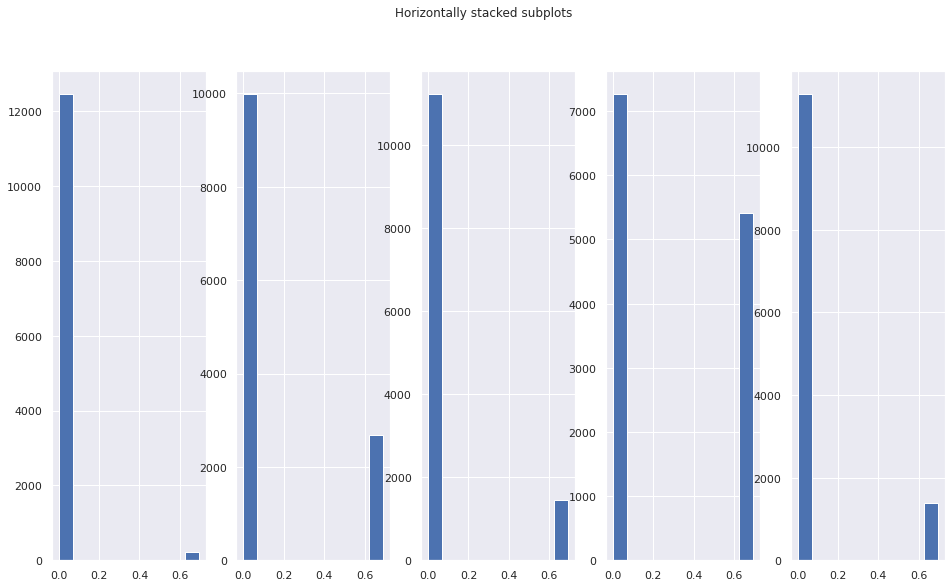

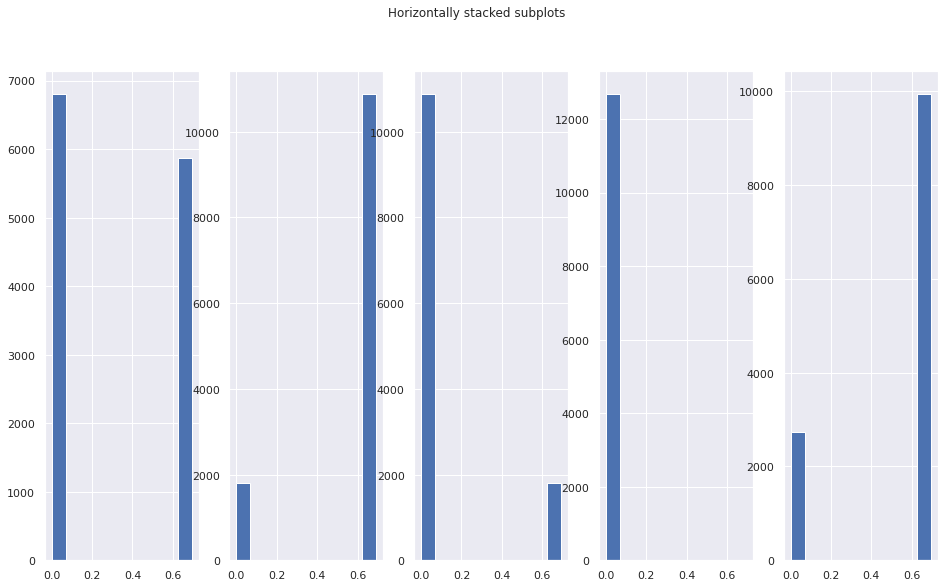

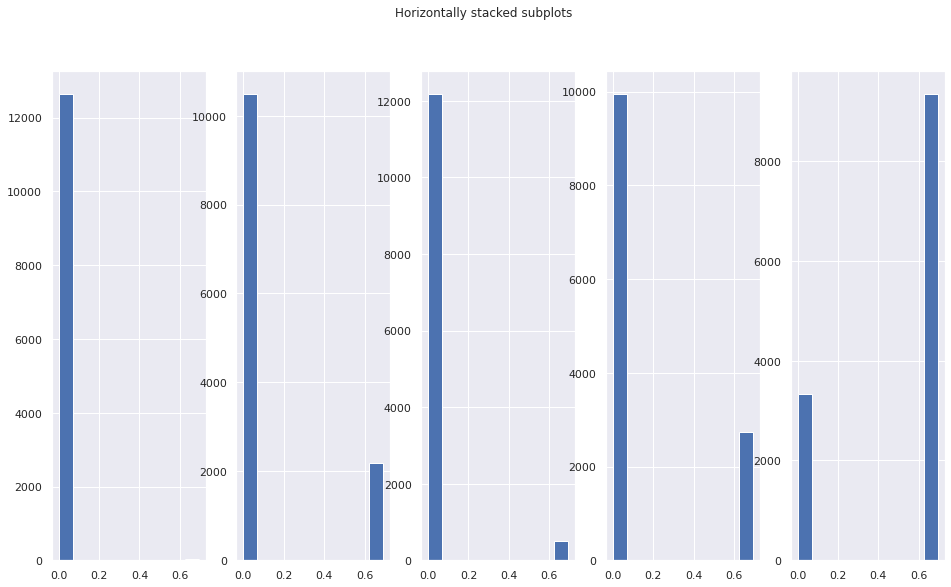

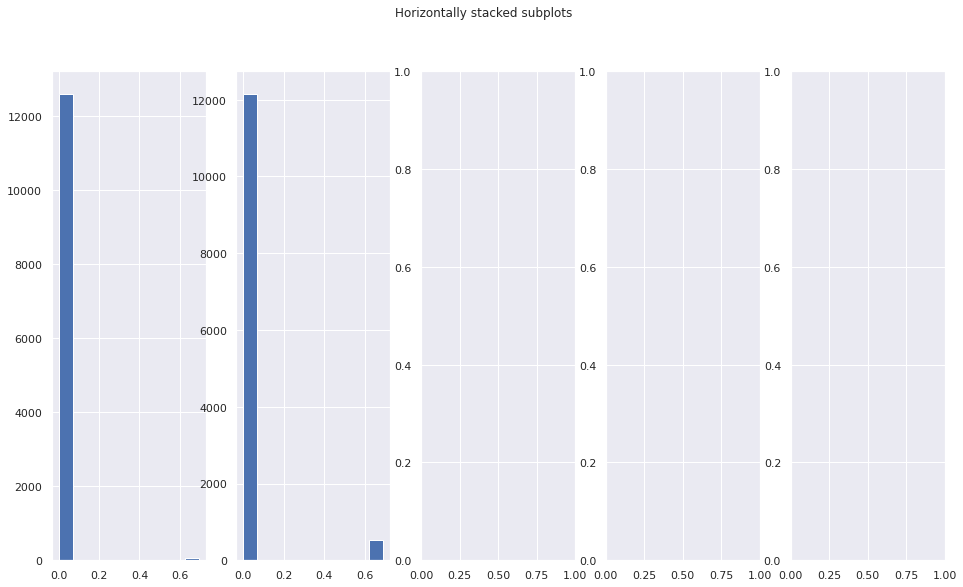

In [90]:
#all_ones = y.sum()
#all_zeros = y.shape[0] - ones
#for col in X.columns:
"""
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)
"""
for i in range(0, X.columns.shape[0], 5):
  fig, ax = plt.subplots(1,5,figsize = (16,9))
  fig.suptitle('Horizontally stacked subplots')
  ax[0].hist(np.log1p(X.iloc[:,i]))
  ax[1].hist(np.log1p(X.iloc[:,i+1]))
  ax[2].hist(np.log1p(X.iloc[:,i+2]))
  ax[3].hist(np.log1p(X.iloc[:,i+3]))
  ax[4].hist(np.log1p(X.iloc[:,i+4]))
  fig.show()


In [ ]:
scaler = StandardScaler()

X[numeric_features] = scaler.fit_transform(X[numeric_features])
X = X.join(ohe_cat_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=66)

In [34]:
(y == 1).sum()

2247

Попробуем сделать для нашего датасета undersampling - сбалансируем классы

In [35]:
default_index = y[y == 1].index
normal_index = y[y == 0].index

random_normal_index = np.random.choice(normal_index, size=default_index.shape[0], replace=False)

undersample_index = np.concatenate([random_normal_index, default_index.values])
X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = train_test_split(X.loc[undersample_index, :],
                                                                                                        y[undersample_index],
                                                                                                   random_state=42,
                                                                                                  train_size=0.75 
                                                                                                  )

In [ ]:
#feature importance 

In [56]:
# класс-пайплайн для тестирования и подбора гиперпараметров
from sklearn.model_selection import GridSearchCV

class ModelPreparation :
    def __init__(self, data, target, verbose=False):
        self.data = data
        self.target = target
        self.verbose = verbose
    
    def define_model(self, estimator):
        """
        Поддерживаются: 
        - LogisticRegression 
        - Random Forest
        - XGBoost
        - CatBoost
        - lgbm
        - Gradient Boost
        идея  функции простая - записать в поле класса нужные параметры для перебора и саму модель
        """
        self.estimator = estimator
        if (estimator is LogisticRegression):
            cs = np.logspace(-3, 3, 7)
            self.parameters = {"C" : cs}  # пока так, можно ещё что-нибудь поподбирать
        elif estimator is RandomForestClassifier:
            n_estimators = np.arange(100, 301, 100)
            depths = np.arange(1, 17, 4)
            min_sample_leaf = np.arange(1, 100, 10)
            self.parameters = {"n_estimators" : n_estimators,
                               "max_depth" : depths, 
                               "min_samples_leaf" : min_sample_leaf}
        elif estimator is xgb.XGBClassifier:
            pass
        elif estimator is CatBoostClassifier:
            pass
        elif estimator is LGBMClassifier:
            pass
        elif estimator is GradientBoostingClassifier:
            pass
        else:
            print("Ругаюсь")
    
    def hyperparameters_tuning(self):
        
        best_parameters_accuracy = {}
        best_parameters_aucroc = {}
        # переберем параметры
        if self.verbose:
            print(self.parameters.keys())
        grid = GridSearchCV(self.estimator(), self.parameters, cv=5)
        grid.fit(self.data, self.target)    
        """
        for parameter in self.parameters.keys():
            # переберем все значения этих параметров
            balanced_accuracy_avg = []
            weighted_auc_roc_avg = []
            for value in self.parameters[parameter]:
                if self.verbose:
                    print(parameter)
                model = self.estimator().set_params(**{parameter : value})
                balanced_accuracy = np.round(cross_val_score(model, self.data, self.target, 
                                                             scoring='accuracy', cv=5), 4)
                weighted_auc_roc = np.round(cross_val_score(model, self.data, self.target, 
                                                            scoring="roc_auc", cv=5), 4)
                balanced_accuracy_avg.append(balanced_accuracy.mean())
                weighted_auc_roc_avg.append(weighted_auc_roc.mean())
            
            best_parameters_accuracy[parameter] = (self.parameters[parameter][np.argmax(balanced_accuracy_avg)],
                                                   max(balanced_accuracy_avg))
            best_parameters_aucroc[parameter] = (self.parameters[parameter][np.argmax(weighted_auc_roc_avg)],
                                                 max(weighted_auc_roc_avg))

        return best_parameters_accuracy, best_parameters_aucroc
        """
        return  grid.best_params_
                

In [53]:
test = ModelPreparation(X_train, y_train)
test.define_model(LogisticRegression)
#best_acc, best_aucroc 
res = test.hyperparameters_tuning()
for key in res.keys():
  print(res[key])
    #print("Best {} value is {} with accuracy score {}".format(key, best_acc[key][0], best_acc[key][1]))
    #print("Best {} value is {} with aucroc {}".format(key, best_aucroc[key][0], best_aucroc[key][1]))

0.001


In [ ]:
test_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_undersample.define_model(LogisticRegression)
best_acc_undersample, best_aucroc_undersample = test_undersample.hyperparameters_tuning()
for key in best_acc_undersample.keys():
    print("Best {} value is {} with accuracy score {} on undersampled data".format(key, best_acc_undersample[key][0], best_acc_undersample[key][1]))
    print("Best {} value is {} with aucroc {} on undersampled data".format(key, best_aucroc_undersample[key][0], best_aucroc_undersample[key][1]))

Best C value is 0.01 with accuracy score 0.65046 on undersampled data
Best C value is 0.01 with aucroc 0.69892 on undersampled data


In [ ]:
test = ModelPreparation(X_train, y_train)
test.define_model(RandomForestClassifier)
#best_acc, best_aucroc 
res = test.hyperparameters_tuning()
for key in res.keys():
  print(res[key])
    #print("Best {} value is {} with accuracy score {}".format(key, best_acc[key][0], best_acc[key][1]))
    #print("Best {} value is {} with aucroc {}".format(key, best_aucroc[key][0], best_aucroc[key][1]))

In [60]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_undersample_train, y_undersample_train)
y_pred = model.predict(X_undersample_test)
print(classification_report(y_pred,y_undersample_test))


              precision    recall  f1-score   support

         0.0       0.52      0.60      0.55       509
         1.0       0.62      0.53      0.57       615

    accuracy                           0.56      1124
   macro avg       0.57      0.57      0.56      1124
weighted avg       0.57      0.56      0.56      1124



In [61]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

         0.0       0.94      0.84      0.88      2935
         1.0       0.12      0.27      0.16       233

    accuracy                           0.79      3168
   macro avg       0.53      0.55      0.52      3168
weighted avg       0.88      0.79      0.83      3168



              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      2620
         1.0       0.56      0.08      0.14       548

    accuracy                           0.83      3168
   macro avg       0.70      0.53      0.52      3168
weighted avg       0.79      0.83      0.77      3168



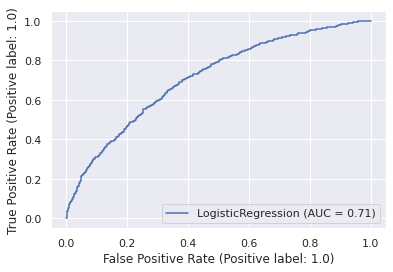

In [ ]:
logres = LogisticRegression()

logres.fit(X_train, y_train)
y_pred1 = logres.predict(X_test)
#print("Accuracy on LogisticRegression=", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
plot_roc_curve(logres, X_test, y_test)

Accuracy on LogisticRegression with undersampling= 0.6628113879003559
              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66       592
         1.0       0.63      0.70      0.66       532

    accuracy                           0.66      1124
   macro avg       0.66      0.66      0.66      1124
weighted avg       0.67      0.66      0.66      1124



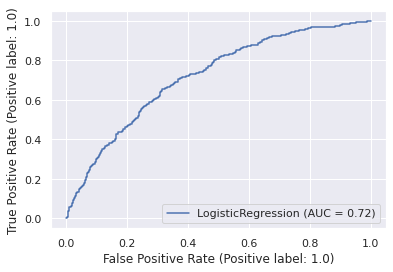

In [ ]:
logres = LogisticRegression()

logres.fit(X_undersample_train, y_undersample_train)
y_pred = logres.predict(X_undersample_test)
print("Accuracy on LogisticRegression with undersampling=", accuracy_score(y_undersample_test, y_pred))
print(classification_report(y_undersample_test, y_pred))
plot_roc_curve(logres, X_undersample_test, y_undersample_test)

Accuracy on AdaBoost Classifier= 0.8295454545454546


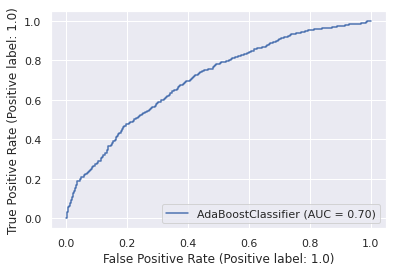

In [ ]:
AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=66)
AdaBoost.fit(X_train, y_train)
y_pred2 = AdaBoost.predict(X_test)

print("Accuracy on AdaBoost Classifier=", accuracy_score(y_test, y_pred2))
plot_roc_curve(AdaBoost, X_test, y_test)

Accuracy with Gradient Boosting : 0.8298611111111112


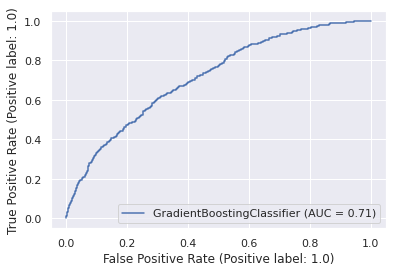

In [ ]:
GradBoost = GradientBoostingClassifier(n_estimators=100, random_state=66)
GradBoost.fit(X_train, y_train)
y_pred3 = GradBoost.predict(X_test)
print("Accuracy with Gradient Boosting :", accuracy_score(y_test, y_pred3))
plot_roc_curve(GradBoost, X_test, y_test)

Accuracy on LGBM Classifier= 0.827020202020202


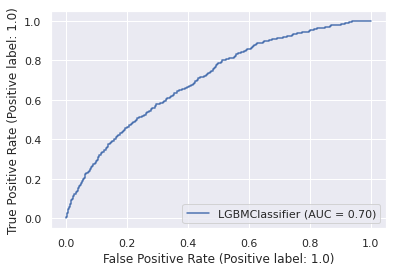

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred4 = lgbm.predict(X_test)
print("Accuracy on LGBM Classifier=", accuracy_score(y_test, y_pred4))
plot_roc_curve(lgbm, X_test, y_test)

LGBM_GetLastError().decode('utf-8') - попробуй декодировать по всем столбцам и выявить плохой - и переименовать - почему то не работает

Accuracy on CatBoost Classifier= 0.8279671717171717
AUC ROC on CatBoost Classifier:


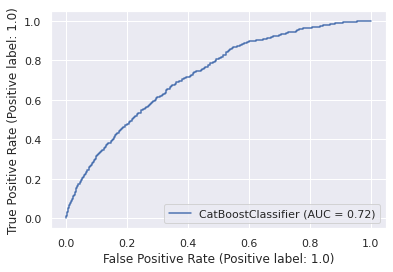

In [ ]:
catBoost = CatBoostClassifier()
catBoost.fit(X_train,y_train,verbose=False)#, plot=True)
y_pred5 = catBoost.predict(X_test)
print("Accuracy on CatBoost Classifier=", accuracy_score(y_test, y_pred5))
print("AUC ROC on CatBoost Classifier:") 
plot_roc_curve(catBoost, X_test, y_test)
#catBoost.score(X_test, y_test)
# тут походу можно просто запихать df изначальный и все скушает

In [ ]:
"""
# небольшой эксперимент с catboost'ом : попробую запихать туда необработанный датасет
model_params = {
    'iterations': 500, 
    'loss_function': 'Logloss', 
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 66,
}

cat_clf = CatBoostClassifier(**model_params)

X_ = df1.drop("Isdefault", axis=1)
y_ = df1["Isdefault"]
y_ = y.iloc[:-2].astype(int)
X_ = X.iloc[:-2, :]

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, train_size=0.8, random_state=66)
cat_clf.fit(X_train_, y_train_)
y_pred_ = cat_clf.predict(X_test_)
print("Accuracy score on raw data with CatBoost Classifier:", accuracy_score(y_test_, y_pred_))
print("Как видно, точность всё таки ниже, чем на обработанных данных => мы сделали предобработку данных неплохо")
"""

NameError: ignored

Accuracy on XGBoost Classifier = 0.8273358585858586
ROC AUC on XGBoost Classifier =


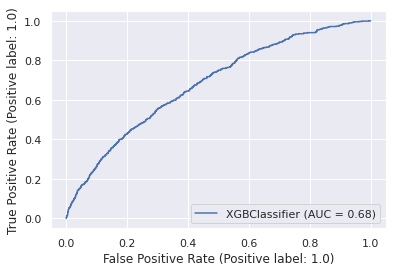

In [ ]:
xg_cl = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_cl.fit(X_train,y_train)

y_pred6 = xg_cl.predict(X_test)
print("Accuracy on XGBoost Classifier =", accuracy_score(y_test, y_pred6))
print("ROC AUC on XGBoost Classifier =")
plot_roc_curve(xg_cl, X_test, y_test)

Accuracy on RandomForest Classifier = 0.8276515151515151
AUC ROC on RandomForest Classifier =


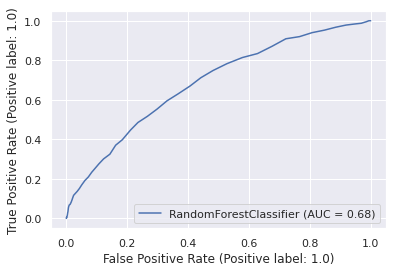

In [ ]:
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train,y_train)

y_pred7 = rf_cl.predict(X_test)
print("Accuracy on RandomForest Classifier =", accuracy_score(y_test, y_pred7))
print("AUC ROC on RandomForest Classifier =")
plot_roc_curve(rf_cl, X_test, y_test)

# Абстрагирование от данного датасета

In [ ]:
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

In [ ]:
data.drop(columns=['ID'], inplace=True)

In [ ]:
data.head()

In [ ]:
# хреновый датасет, оч мало признаков

In [ ]:
df = pd.read_csv("train_v2.csv")
df.head()